# Chromophore Optical Properties Prediction


In this project I aim to build machine learning models to predict optical properties (absorption maximum and emission maximum) of chromophores when placed in different solvents.

**Key Goals:**
- Build Random Forest regression models to predict abs_max (nm) and em_max (nm)
- Extract molecular features using RDKit descriptors and Morgan fingerprints 
- Train models that can predict properties for chromophores (never seen during training) in known solvents
- Use chromophore-based data splitting to properly test generalization
- Analyze solvatochromism - how optical properties change with solvent

The dataset is derived from the Deep4Chem database containing optical properties of chromophore-solvent pairs.


## Setup and Package Versions


In [5]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, AllChem

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import digichem as dc

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

## Data Loading

We firstly load the data from the deep4chem database

In [6]:
df_raw = pd.read_csv('Deep4Chem.csv')

print(f"Dataset loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")
print(f"\nTotal measurements: {len(df_raw):,}")
print(f"Unique chromophores: {df_raw['Chromophore'].nunique():,}")
print(f"Unique solvents: {df_raw['Solvent'].nunique():,}")
print(f"\nMissing values in target columns:")
print(f"Absorption max (nm): {df_raw['Absorption max (nm)'].isna().sum()}")
print(f"Emission max (nm): {df_raw['Emission max (nm)'].isna().sum()}")

Dataset loaded: 20236 rows, 14 columns

Total measurements: 20,236
Unique chromophores: 6,815
Unique solvents: 1,336

Missing values in target columns:
Absorption max (nm): 2941
Emission max (nm): 2094


# Data Preprocessing

We firstly remove all rows with:
- Invalid SMILES
- Absulte emission and Absolute absorption values with `Nan`

In [7]:
columns_to_keep = ['Chromophore', 'Solvent', 'Absorption max (nm)', 'Emission max (nm)']
df = df_raw[columns_to_keep].copy()

print(f"Starting with {len(df):,} measurements")

# Remove rows with missing targets
df = df.dropna(subset=['Absorption max (nm)', 'Emission max (nm)'])
print(f"After removing missing targets: {len(df):,} measurements")

df = df.rename(columns={
    'Absorption max (nm)': 'abs_max',
    'Emission max (nm)': 'em_max'
})

def is_valid_smiles(smiles):
    if pd.isna(smiles):
        return False
    mol = Chem.MolFromSmiles(str(smiles))
    return mol is not None

df['valid_chromophore'] = df['Chromophore'].apply(is_valid_smiles)
df['valid_solvent'] = df['Solvent'].apply(is_valid_smiles)

print(f"Invalid chromophore SMILES: {(~df['valid_chromophore']).sum()}")
print(f"Invalid solvent SMILES: {(~df['valid_solvent']).sum()}")

df = df[df['valid_chromophore'] & df['valid_solvent']].copy()
df = df.drop(columns=['valid_chromophore', 'valid_solvent'])

df = df.reset_index(drop=True)

print(f"\nFinal clean dataset: {len(df):,} measurements")
print(f"Unique chromophores: {df['Chromophore'].nunique():,}")
print(f"Unique solvents: {df['Solvent'].nunique():,}")


Starting with 20,236 measurements
After removing missing targets: 16,022 measurements
Invalid chromophore SMILES: 0
Invalid solvent SMILES: 1

Final clean dataset: 16,021 measurements
Unique chromophores: 6,085
Unique solvents: 457


[02:26:52] SMILES Parse Error: syntax error while parsing: gas
[02:26:52] SMILES Parse Error: check for mistakes around position 1:
[02:26:52] gas
[02:26:52] ^
[02:26:52] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'


See most common solvents and chromorphores in our dataset

In [8]:
# Top 10 most common solvents
print("Top 10 Most Common Solvents:")
top_solvents = df['Solvent'].value_counts().head(10)
for i, (solvent, count) in enumerate(top_solvents.items(), 1):
    print(f"{i:2d}. {solvent:30s} - {count:4d} measurements")

# Top 10 most measured chromophores
print("\nTop 10 Most Measured Chromophores:")
top_chromophores = df['Chromophore'].value_counts().head(10)
for i, (chrom, count) in enumerate(top_chromophores.items(), 1):
    chrom_display = chrom[:50] + '...' if len(chrom) > 50 else chrom
    print(f"{i:2d}. {chrom_display} - {count:4d} measurements")

Top 10 Most Common Solvents:
 1. ClCCl                          - 2320 measurements
 2. CC#N                           - 1693 measurements
 3. Cc1ccccc1                      - 1297 measurements
 4. ClC(Cl)Cl                      - 1199 measurements
 5. C1CCOC1                        - 1190 measurements
 6. CO                             - 1089 measurements
 7. CCO                            -  785 measurements
 8. CS(C)=O                        -  651 measurements
 9. C1CCCCC1                       -  636 measurements
10. CN(C)C=O                       -  591 measurements

Top 10 Most Measured Chromophores:
 1. COC(=O)C(Cc1ccc2oc(-c3ccc4c(c3)c3ccccc3n4-c3ccccc3... -   36 measurements
 2. COC(=O)C(Cc1ccc2oc(-c3ccc(N(C)C)cc3)nc2c1)NC(=O)OC... -   36 measurements
 3. COC(=O)C(Cc1ccc2oc(-c3ccc(Nc4ccccc4)cc3)nc2c1)NC(=... -   36 measurements
 4. COC(=O)C(Cc1ccc2oc(-c3ccc(N(C)c4ccccc4)cc3)nc2c1)N... -   35 measurements
 5. CCC(=O)c1ccc2cc(N(C)C)ccc2c1 -   31 measurements
 6. CN(C)c1cc(C#N)c(

## Feature Engineering

Picking out features that we'll use for the training:
1. RDKit Molecular Descriptors
2. Morgan Fingerprints

These features will be extracted for both chromophores and solvents.

In [13]:
def extract_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'MolLogP': Descriptors.MolLogP(mol),
        'NumAromaticRings': Lipinski.NumAromaticRings(mol),
        'NumAromaticCarbocycles': Lipinski.NumAromaticCarbocycles(mol),
        'NumAromaticHeterocycles': Lipinski.NumAromaticHeterocycles(mol),
        'NumHeteroatoms': Lipinski.NumHeteroatoms(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Lipinski.NumRotatableBonds(mol),
        'NumSaturatedRings': Lipinski.NumSaturatedRings(mol),
        'FractionCSP3': Lipinski.FractionCSP3(mol),
        'BertzCT': Descriptors.BertzCT(mol),
        'HallKierAlpha': Descriptors.HallKierAlpha(mol)
    }
    
    return descriptors

def extract_morgan_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    morgan_generator = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
    fp = morgan_generator.GetFingerprint(mol)
    # fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return np.array(fp, dtype=np.uint8)


In [14]:
chrom_desc_list = []
for smiles in df['Chromophore']:
    desc = extract_molecular_descriptors(smiles)
    chrom_desc_list.append(desc)

chrom_desc_df = pd.DataFrame(chrom_desc_list)
chrom_desc_df.columns = ['chrom_desc_' + col for col in chrom_desc_df.columns]
print(f"Chromophore descriptors: {chrom_desc_df.shape}")

chrom_fp_list = []
for smiles in df['Chromophore']:
    fp = extract_morgan_fingerprint(smiles)
    chrom_fp_list.append(fp)

# Convert to DataFrame
chrom_fp_df = pd.DataFrame(chrom_fp_list, dtype=np.uint8)
chrom_fp_df.columns = ['chrom_fp_' + str(i) for i in range(chrom_fp_df.shape[1])]
print(f"Chromophore fingerprints: {chrom_fp_df.shape}")


## Solvent features

solv_desc_list = []
for smiles in df['Solvent']:
    desc = extract_molecular_descriptors(smiles)
    solv_desc_list.append(desc)

solv_desc_df = pd.DataFrame(solv_desc_list)
solv_desc_df.columns = ['solv_desc_' + col for col in solv_desc_df.columns]
print(f"Solvent descriptors: {solv_desc_df.shape}")

solv_fp_list = []
for smiles in df['Solvent']:
    fp = extract_morgan_fingerprint(smiles)
    solv_fp_list.append(fp)

solv_fp_df = pd.DataFrame(solv_fp_list, dtype=np.uint8)
solv_fp_df.columns = ['solv_fp_' + str(i) for i in range(solv_fp_df.shape[1])]
print(f"Solvent fingerprints: {solv_fp_df.shape}")


Chromophore descriptors: (16021, 12)
Chromophore fingerprints: (16021, 2048)
Solvent descriptors: (16021, 12)
Solvent fingerprints: (16021, 2048)


In [15]:
# Combine all features
X = pd.concat([chrom_desc_df, chrom_fp_df, solv_desc_df, solv_fp_df], axis=1)

# Convert to float32 for memory efficiency
for col in chrom_desc_df.columns.tolist() + solv_desc_df.columns.tolist():
    X[col] = X[col].astype(np.float32)

y_abs = df['abs_max'].values
y_em = df['em_max'].values

print(f"Feature matrix X: {X.shape}")
print(f"Chromophore descriptors: {len(chrom_desc_df.columns)}")
print(f"Chromophore fingerprints: {len(chrom_fp_df.columns)}")
print(f"Solvent descriptors: {len(solv_desc_df.columns)}")
print(f"Solvent fingerprints: {len(solv_fp_df.columns)}")
print(f"Total features: {X.shape[1]}")

Feature matrix X: (16021, 4120)
Chromophore descriptors: 12
Chromophore fingerprints: 2048
Solvent descriptors: 12
Solvent fingerprints: 2048
Total features: 4120


## Data Splitting

Now we split the data into three parts:
- Training data
- Validation data
- Testing data

In order for our goal of predicting properties of completely new solvents to occur, we must validate and test it on chromophores that we have not trained on

Therefore we make sure to have no overlap between training and validaton and testing data

In [17]:
unique_chromophores = df['Chromophore'].unique()

chrom_train, chrom_temp = train_test_split(unique_chromophores, test_size=0.30, random_state=RANDOM_STATE)
chrom_val, chrom_test = train_test_split(chrom_temp, test_size=0.50, random_state=RANDOM_STATE)

print(f"\nChromophore split:")
print(f"Train chromophores: {len(chrom_train):,} ({len(chrom_train)/len(unique_chromophores)*100:.1f}%)")
print(f"Val chromophores:   {len(chrom_val):,} ({len(chrom_val)/len(unique_chromophores)*100:.1f}%)")
print(f"Test chromophores:  {len(chrom_test):,} ({len(chrom_test)/len(unique_chromophores)*100:.1f}%)")


Chromophore split:
Train chromophores: 4,259 (70.0%)
Val chromophores:   913 (15.0%)
Test chromophores:  913 (15.0%)


In [19]:
train_idx = df['Chromophore'].isin(chrom_train)
val_idx = df['Chromophore'].isin(chrom_val)
test_idx = df['Chromophore'].isin(chrom_test)

# features
X_train = X[train_idx].reset_index(drop=True)
X_val = X[val_idx].reset_index(drop=True)
X_test = X[test_idx].reset_index(drop=True)

# abs_max
y_abs_train = y_abs[train_idx]
y_abs_val = y_abs[val_idx]
y_abs_test = y_abs[test_idx]

# em_max
y_em_train = y_em[train_idx]
y_em_val = y_em[val_idx]
y_em_test = y_em[test_idx]

print("\nMeasurement split:")
print(f"Train: {len(X_train):,} measurements ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val):,} measurements ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test):,} measurements ({len(X_test)/len(X)*100:.1f}%)")


Measurement split:
Train: 11,340 measurements (70.8%)
Val:   2,332 measurements (14.6%)
Test:  2,349 measurements (14.7%)


# Visualize distribution of data split

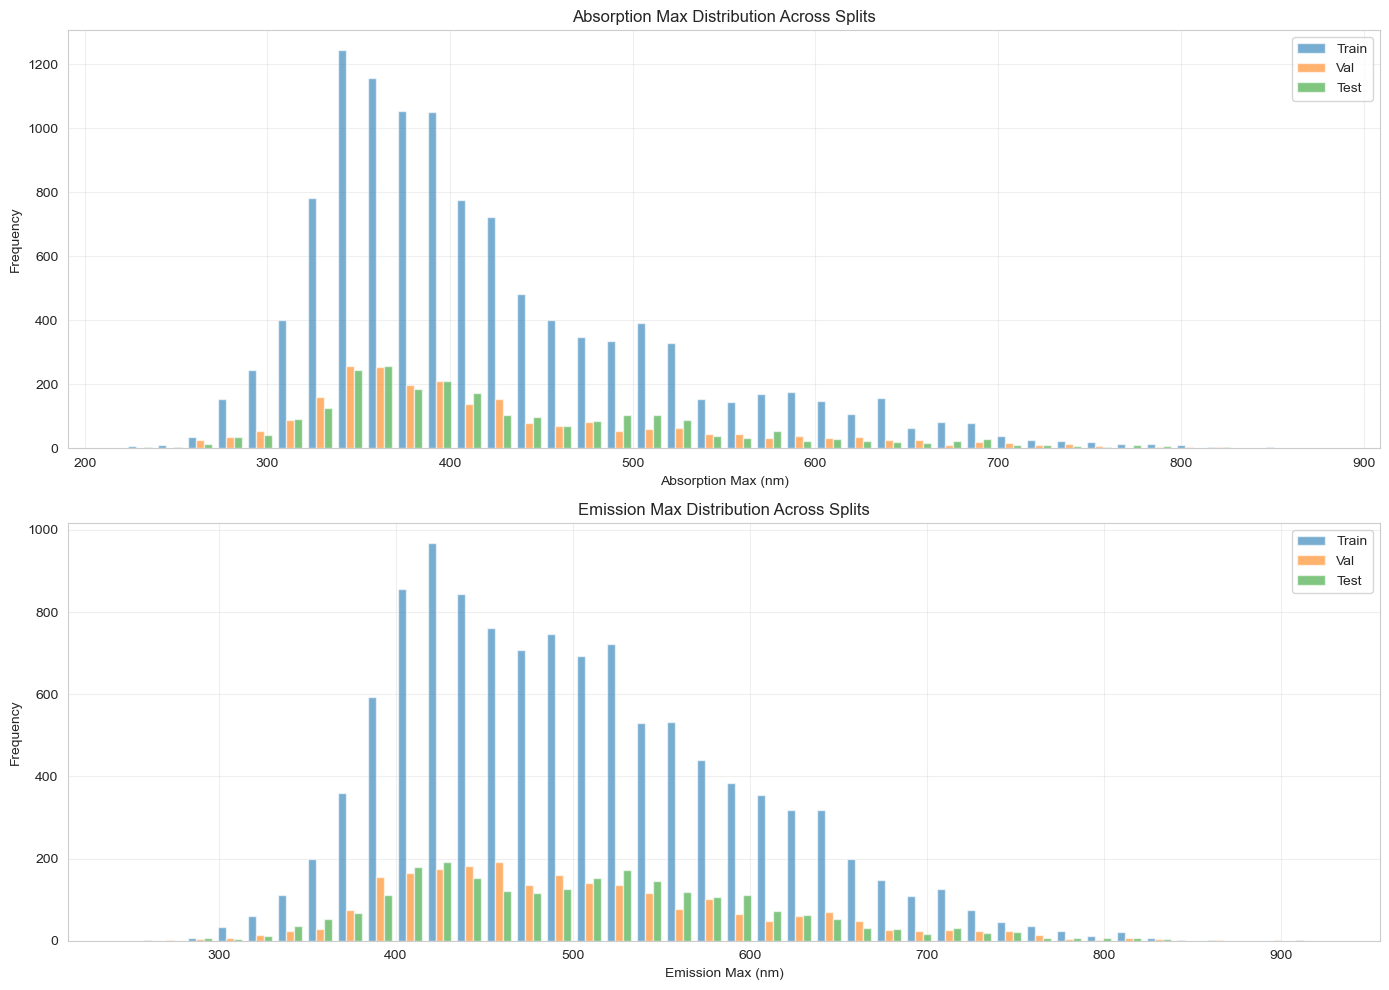

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Absorption distributions
axes[0].hist([y_abs_train, y_abs_val, y_abs_test], bins=40, label=['Train', 'Val', 'Test'], alpha=0.6)
axes[0].set_xlabel('Absorption Max (nm)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Absorption Max Distribution Across Splits')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Emission distributions
axes[1].hist([y_em_train, y_em_val, y_em_test], bins=40, label=['Train', 'Val', 'Test'], alpha=0.6)
axes[1].set_xlabel('Emission Max (nm)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Emission Max Distribution Across Splits')
axes[1].legend()
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


## Hyperparameter Tuning with RandomizedSearchCV

We'll tune hyperparameters using RandomizedSearchCV, which samples random parameter combinations rather than exhaustively testing all options. This is much faster while still finding good parameters.

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter distributions for Random Forest
param_distributions = {
    'rf__n_estimators': randint(50, 300),
    'rf__max_depth': [None, 10, 20, 30, 50],
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 10)
}

# Create base pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

print("Starting RandomizedSearchCV for Absorption Max model...")
print("Testing 20 random parameter combinations with 3-fold CV\n")

# RandomizedSearchCV for absorption model
random_search_abs = RandomizedSearchCV(
    rf_pipeline,
    param_distributions,
    n_iter=50,  # Only test 20 random combinations
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

random_search_abs.fit(X_train, y_abs_train)

print(f"\nBest parameters for Absorption: {random_search_abs.best_params_}")
print(f"Best CV R² score: {random_search_abs.best_score_:.4f}")


Starting RandomizedSearchCV for Absorption Max model...
Testing 20 random parameter combinations with 3-fold CV

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters for Absorption: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 269}
Best CV R² score: 0.6117


In [25]:
# Use the best estimator from RandomizedSearchCV
rf_abs_pipeline = random_search_abs.best_estimator_

def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    root_mean_sq = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: {root_mean_sq:.2f} nm")
    
    return {'R2': r2, 'RMSE': root_mean_sq}

# Evaluate on train and validation
y_abs_train_pred = rf_abs_pipeline.predict(X_train)
y_abs_val_pred = rf_abs_pipeline.predict(X_val)

print("Absorption Model (with tuned hyperparameters):\n")
print("Training Set Performance:")
train_metrics = evaluate_model(y_abs_train, y_abs_train_pred)
print("\nValidation Set Performance:")
val_metrics = evaluate_model(y_abs_val, y_abs_val_pred)

Absorption Model (with tuned hyperparameters):

Training Set Performance:
R2 Score: 0.9866
RMSE: 11.08 nm

Validation Set Performance:
R2 Score: 0.8189
RMSE: 44.30 nm


## Hyperparameter Tuning for Emission Model

In [24]:
print("Starting RandomizedSearchCV for Emission Max model...")
print("Testing 20 random parameter combinations with 3-fold CV\n")

# RandomizedSearchCV for emission model
random_search_em = RandomizedSearchCV(
    rf_pipeline,
    param_distributions,
    n_iter=50,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

random_search_em.fit(X_train, y_em_train)

print(f"\nBest parameters for Emission: {random_search_em.best_params_}")
print(f"Best CV R² score: {random_search_em.best_score_:.4f}")

# Use the best estimator
rf_em_pipeline = random_search_em.best_estimator_


Starting RandomizedSearchCV for Emission Max model...
Testing 20 random parameter combinations with 3-fold CV

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters for Emission: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 269}
Best CV R² score: 0.5004


In [26]:
y_em_train_pred = rf_em_pipeline.predict(X_train)
y_em_val_pred = rf_em_pipeline.predict(X_val)

print("Emission Model (with tuned hyperparameters):\n")
print("Training Set Performance:")
train_metrics_em = evaluate_model(y_em_train, y_em_train_pred)
print("\nValidation Set Performance:")
val_metrics_em = evaluate_model(y_em_val, y_em_val_pred)

Emission Model (with tuned hyperparameters):

Training Set Performance:
R2 Score: 0.9751
RMSE: 14.90 nm

Validation Set Performance:
R2 Score: 0.7428
RMSE: 50.32 nm


## Evaluate Tuned Models on Test Data

In [27]:
# Predict on test set
y_abs_test_pred = rf_abs_pipeline.predict(X_test)
y_em_test_pred = rf_em_pipeline.predict(X_test)


print("Absorption Max Model:")
test_metrics_abs = evaluate_model(y_abs_test, y_abs_test_pred)

print("Emission Max Model:")
test_metrics_em = evaluate_model(y_em_test, y_em_test_pred)


Absorption Max Model:
R2 Score: 0.8098
RMSE: 44.48 nm
Emission Max Model:
R2 Score: 0.7138
RMSE: 52.77 nm


/var/folders/ht/gqgzyvm53pl2nndpbbttkb640000gn/T/ipykernel_39670/1826667433.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=residual_df, x='Model', y='Residual (nm)',


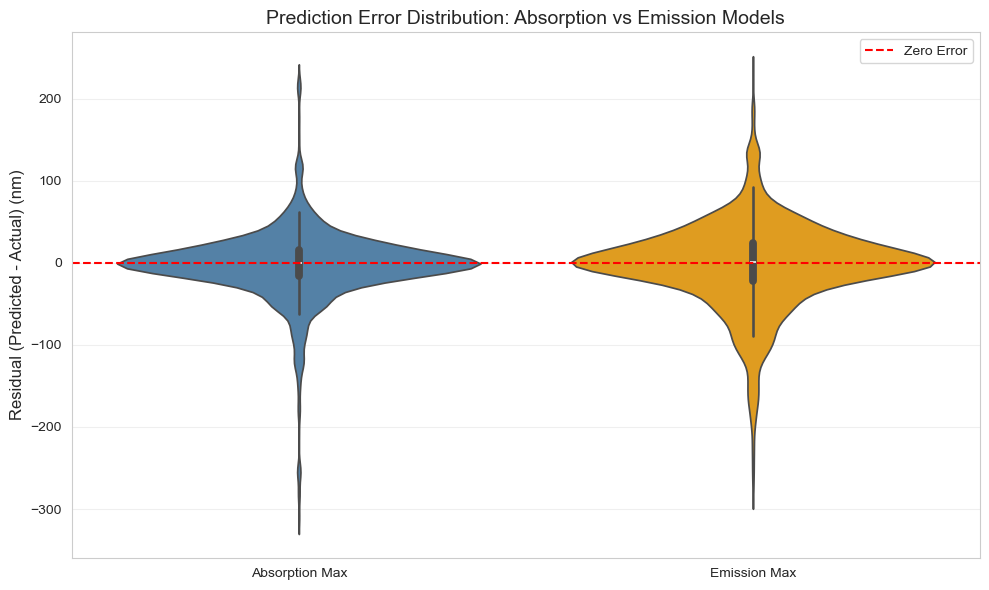

Absorption residuals: mean=-3.36 nm, std=44.35 nm
Emission residuals:   mean=-3.28 nm, std=52.67 nm


In [28]:
# Calculate residuals for both models
residuals_abs = y_abs_test_pred - y_abs_test
residuals_em = y_em_test_pred - y_em_test

# Build DataFrame for violin plot
residual_df = pd.DataFrame({
    'Residual (nm)': np.concatenate([residuals_abs, residuals_em]),
    'Model': ['Absorption Max'] * len(residuals_abs) + ['Emission Max'] * len(residuals_em)
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(data=residual_df, x='Model', y='Residual (nm)', 
               inner='box', palette=['steelblue', 'orange'], ax=ax)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')
ax.set_title('Prediction Error Distribution: Absorption vs Emission Models', fontsize=14)
ax.set_ylabel('Residual (Predicted - Actual) (nm)', fontsize=12)
ax.set_xlabel('')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Absorption residuals: mean={residuals_abs.mean():.2f} nm, std={residuals_abs.std():.2f} nm")
print(f"Emission residuals:   mean={residuals_em.mean():.2f} nm, std={residuals_em.std():.2f} nm")

# Solvatochromism Analysis

If we take the Max Absorption and Max Emission values in different solvents, we should see that as we move from more polar to less polar solvents, we should see a shift in the values for Absorption/Emission as well, which indicates that the model has modelled solvatochromism accurately

In [29]:
# SMILES to readable names (ordered from polar to non-polar)
solvent_names = {
    'CO': 'Methanol',
    'CN(C)C=O': 'DMF',
    'C1CCOC1': 'THF',
    'ClC(Cl)Cl': 'Chloroform',
    'C1CCCCC1': 'Cyclohexane',
}

target_solvents = set(solvent_names.keys())

chromophore_solvents = df.groupby('Chromophore')['Solvent'].apply(set)
chroms_with_all_5 = chromophore_solvents[chromophore_solvents.apply(lambda x: target_solvents.issubset(x))].index.tolist()

print(f"Chromophores measured in all 5 solvents: {len(chroms_with_all_5)}")

Chromophores measured in all 5 solvents: 40


In [30]:
from scipy.stats import spearmanr

solvent_polarity = {
    'CO': 1,         
    'CN(C)C=O': 2,   
    'C1CCOC1': 3,    
    'ClC(Cl)Cl': 4,  
    'C1CCCCC1': 5,   
}

df_solvato = df[
    (df['Chromophore'].isin(chroms_with_all_5)) & 
    (df['Solvent'].isin(target_solvents))
].copy()

df_solvato['polarity_order'] = df_solvato['Solvent'].map(solvent_polarity)

solvato_results = []

for chrom in chroms_with_all_5:
    chrom_data = df_solvato[df_solvato['Chromophore'] == chrom].sort_values('polarity_order')
    
    abs_corr, abs_pval = spearmanr(chrom_data['polarity_order'], chrom_data['abs_max'])
    em_corr, em_pval = spearmanr(chrom_data['polarity_order'], chrom_data['em_max'])
    
    abs_range = chrom_data['abs_max'].max() - chrom_data['abs_max'].min()
    em_range = chrom_data['em_max'].max() - chrom_data['em_max'].min()
    
    solvato_results.append({
        'Chromophore': chrom,
        'abs_corr': abs_corr,
        'em_corr': em_corr,
        'abs_range': abs_range,
        'em_range': em_range,
        'avg_corr': (abs(abs_corr) + abs(em_corr)) / 2
    })

solvato_df = pd.DataFrame(solvato_results)

# Filter: keep only chromophores with strong correlation (|r| > 0.7 for either abs or em)
# This means there's a clear trend with polarity
threshold = 0.7
solvatochromic_mask = (abs(solvato_df['abs_corr']) > threshold) | (abs(solvato_df['em_corr']) > threshold)
solvatochromic_chroms = solvato_df[solvatochromic_mask].sort_values('avg_corr', ascending=False)


# Store the list of solvatochromic chromophores for later use
solvatochromic_chrom_list = solvatochromic_chroms['Chromophore'].tolist()
print(f"\n{len(solvatochromic_chrom_list)} chromophores exhibit solvatochromism")


30 chromophores exhibit solvatochromism


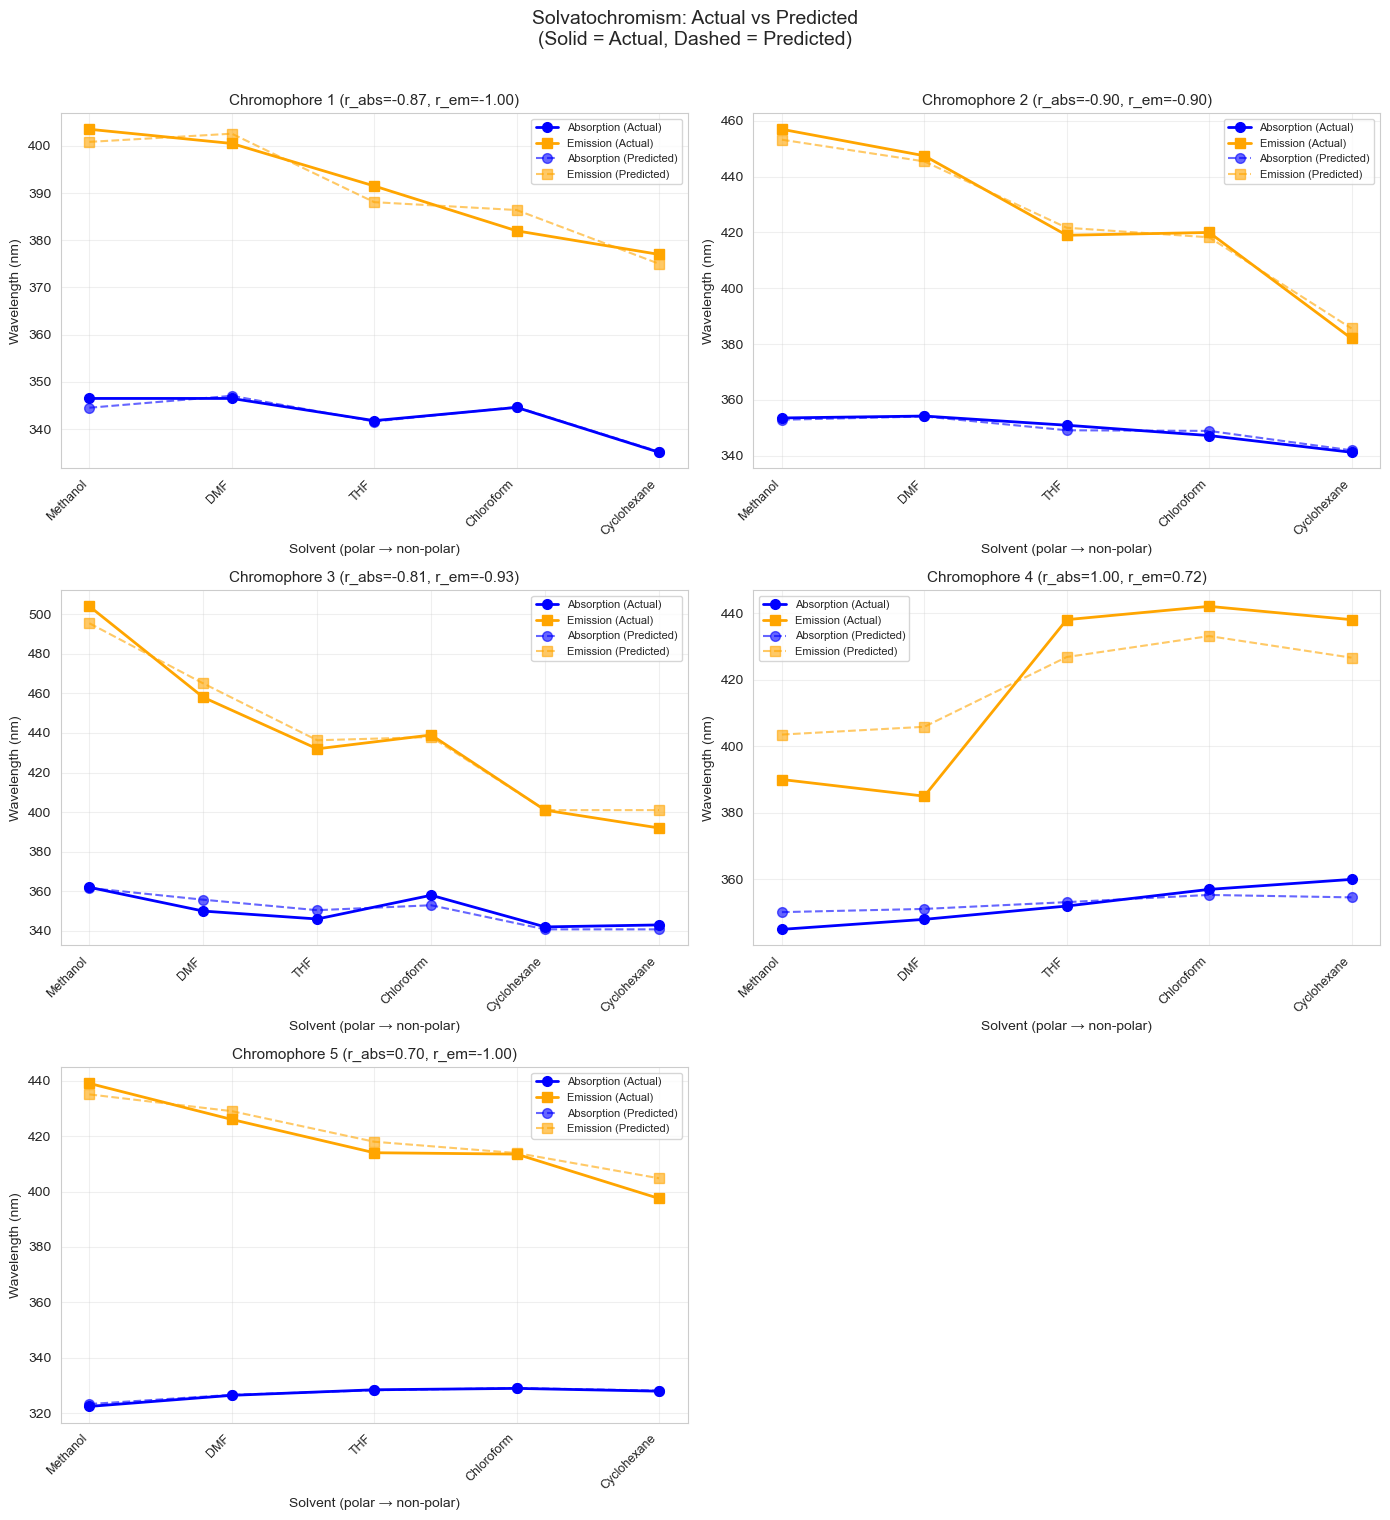

In [31]:
# First, generate predictions for the solvatochromism data
solvato_indices = df_solvato.index.tolist()
X_solvato = X.loc[solvato_indices]
df_solvato['abs_pred'] = rf_abs_pipeline.predict(X_solvato)
df_solvato['em_pred'] = rf_em_pipeline.predict(X_solvato)

# Plot 3x2 grid: Actual and Predicted combined on the same axes
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

for idx, chrom in enumerate(solvatochromic_chrom_list[:5]):
    row, col = divmod(idx, 2)
    chrom_data = df_solvato[df_solvato['Chromophore'] == chrom].copy()
    chrom_data['Solvent_Name'] = chrom_data['Solvent'].map(solvent_names)
    chrom_data = chrom_data.sort_values('polarity_order')
    
    x = range(len(chrom_data))
    chrom_info = solvatochromic_chroms[solvatochromic_chroms['Chromophore'] == chrom].iloc[0]
    
    ax = axes[row, col]
    
    # Actual values (solid lines)
    ax.plot(x, chrom_data['abs_max'], 'o-', label='Absorption (Actual)', color='blue', markersize=7, linewidth=2)
    ax.plot(x, chrom_data['em_max'], 's-', label='Emission (Actual)', color='orange', markersize=7, linewidth=2)
    
    # Predicted values (dashed lines)
    ax.plot(x, chrom_data['abs_pred'], 'o--', label='Absorption (Predicted)', color='blue', markersize=7, linewidth=1.5, alpha=0.6)
    ax.plot(x, chrom_data['em_pred'], 's--', label='Emission (Predicted)', color='orange', markersize=7, linewidth=1.5, alpha=0.6)
    
    ax.set_xlabel('Solvent (polar → non-polar)', fontsize=10)
    ax.set_ylabel('Wavelength (nm)', fontsize=10)
    ax.set_title(f'Chromophore {idx + 1} (r_abs={chrom_info["abs_corr"]:.2f}, r_em={chrom_info["em_corr"]:.2f})', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(chrom_data['Solvent_Name'], rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

# Hide the empty 6th subplot (row 2, col 1)
axes[2, 1].set_visible(False)

plt.suptitle('Solvatochromism: Actual vs Predicted\n(Solid = Actual, Dashed = Predicted)', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# Stokes Shift Analysis

The Stokes shift is the difference between emission and absorption wavelengths (emission - absorption). Let's compare actual vs predicted Stokes shifts to see how well our model captures this relationship.

In [32]:
np.random.seed(RANDOM_STATE)
sample_indices = np.random.choice(len(df), size=500, replace=False)

df_sample = df.iloc[sample_indices].copy()
X_sample = X.iloc[sample_indices]

df_sample['actual_stokes'] = df_sample['em_max'] - df_sample['abs_max']

# Predict absorption and emission using our models
df_sample['abs_pred'] = rf_abs_pipeline.predict(X_sample)
df_sample['em_pred'] = rf_em_pipeline.predict(X_sample)

df_sample['pred_stokes'] = df_sample['em_pred'] - df_sample['abs_pred']

print(f"Sampled {len(df_sample)} data points")
print(f"\nActual Stokes shift: {df_sample['actual_stokes'].mean():.1f} ± {df_sample['actual_stokes'].std():.1f} nm")
print(f"Predicted Stokes shift: {df_sample['pred_stokes'].mean():.1f} ± {df_sample['pred_stokes'].std():.1f} nm")

Sampled 500 data points

Actual Stokes shift: 80.9 ± 49.0 nm
Predicted Stokes shift: 81.1 ± 43.8 nm


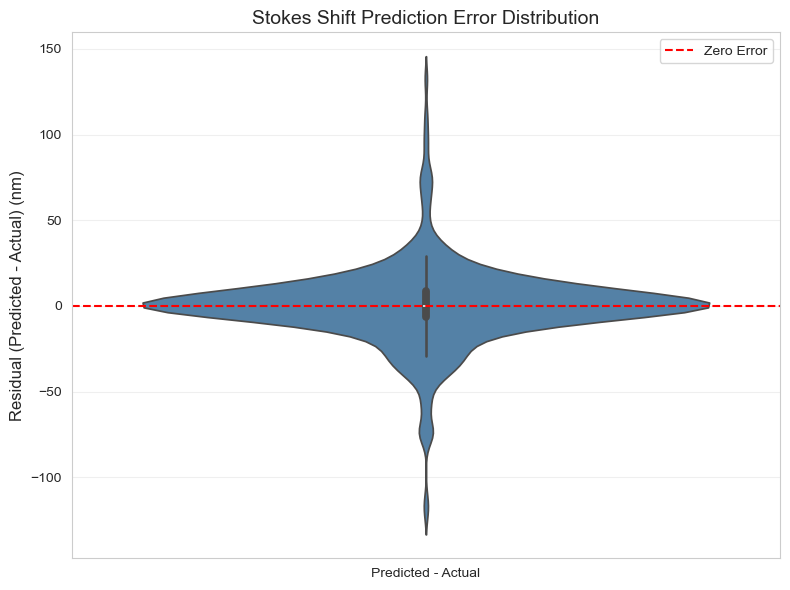

Stokes shift residuals: mean=0.17 nm, std=23.14 nm


In [33]:
# Calculate residuals of Stokes shift (predicted - actual)
stokes_residuals = df_sample['pred_stokes'].values - df_sample['actual_stokes'].values

stokes_resid_df = pd.DataFrame({
    'Stokes Shift Residual (nm)': stokes_residuals,
    'Type': ['Predicted - Actual'] * len(stokes_residuals)
})

fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(data=stokes_resid_df, x='Type', y='Stokes Shift Residual (nm)',
               inner='box', color='steelblue', ax=ax)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')
ax.set_title('Stokes Shift Prediction Error Distribution', fontsize=14)
ax.set_ylabel('Residual (Predicted - Actual) (nm)', fontsize=12)
ax.set_xlabel('')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Stokes shift residuals: mean={stokes_residuals.mean():.2f} nm, std={stokes_residuals.std():.2f} nm")